In [1]:
import torch
import torch.fx as fx
import numpy as np
from torch.fx import symbolic_trace
from torch import nn
import torchvision
from torchvision import models
from torchvision import transforms
from PIL import Image
from scipy.stats import ttest_ind
import torch.optim as optim
import math
import torchvision
import pandas as pd
from numpy import array
from numpy.linalg import norm
from torch.optim import lr_scheduler
import seaborn as sns
from matplotlib import pyplot as plt
import h5py
from sklearn.metrics import accuracy_score

In [39]:
def get_few_shot_learing_data(_class, shot_number, trainloader):
    dataiter = iter(trainloader)
    _data = [ [] for i in range(len(_class))]
    _data_label = [ [] for i in range(len(_class))]
    i=0
    while True:
        image, label = dataiter.next()
        if i<100:
            i+=1
            continue
        if label in _class:
            if len(_data[label])!=shot_number:
                _data[label].append(image)
                _data_label[label].append(label)

        if sum([len(tab) for tab in _data]) ==   shot_number * len(_class):
             break

    out_data= []
    out_label= [] 

    out_data_tensor = torch.Tensor(len(_class)*shot_number,3, 224, 224)
    out_label_tensor= torch.Tensor(len(_class)*shot_number)

    for i in range(len(_class)):
        for j in range(shot_number):
            out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))        
            out_label.append(torch.tensor(_data_label[i][j]).clone().detach()) 

    torch.cat(out_data , out=out_data_tensor)    
    torch.cat(out_label , out=out_label_tensor)    
    out_data_tensor=out_data_tensor.squeeze()
    out_label_tensor = out_label_tensor.type(torch.long)
    trainset_few_shot = out_data_tensor.squeeze(),out_label_tensor.squeeze()
    return trainset_few_shot



In [3]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context # remove for non-buggy env

np.random.seed = 123
torch.manual_seed(0)

transform = transforms.Compose([transforms.Resize(224),
             transforms.ToTensor(),
             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), ])


trainset = torchvision.datasets.CIFAR100(root='./data',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=False, num_workers=2)


_class = [i for i in range(30)]
shot_number = 3

trainset_few_shot = get_few_shot_learing_data(_class,shot_number,trainloader)


Files already downloaded and verified


C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_14552\3293775616.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))
C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_14552\3293775616.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_label.append(torch.tensor(_data_label[i][j]).clone().detach())


In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # remove for non-buggy env

In [5]:
len(trainset_few_shot[0])

90

In [24]:

class ATL(nn.Module):
    def __init__(self, train, Nlayer=3):
        # call constructor from superclass
        Nclasses = len(np.unique(train[1]))
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.relu = nn.ReLU()
        layers, R_scores_for_layers = self.get_layers(train, Nlayer)
        k = sns.lineplot(x=[i+1 for i in range(len(R_scores_for_layers))], y=R_scores_for_layers)
        k.set(ylim=(0, 1))
        plt.show()
        fm_indicies, resnet_out_size = self.get_featuremaps_idicies(train,layers, R_scores_for_layers) 
        self.resnet = self._transform( Nlayer, layers, fm_indicies)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.fcl = nn.Linear(resnet_out_size, Nclasses)
        self.softmax = torch.nn.Softmax(-1)
            
    def get_layers(self, train, number_of_layers):
        images, labels = train
        conv_layers, model_weights = self.get_resnet_conv_layers()
        feature_map_outputs_for_images = [self.get_feature_map_outputs(image) for image in images]
        labels_set = set(np.asarray(labels))
        
        R_scores_for_layers = []
        r_mean=[]
        r_max=[]
        for conv_ind in range(len(conv_layers)):
            
            centroids_for_class =[]
            LAV_vec = []             
                                
            for image_ind, image in enumerate(images):
                LAV_vec_image = []
                out_fm = feature_map_outputs_for_images[image_ind]
                for fm_ind in range(len(model_weights[conv_ind])):
                    LAV_vec_image.append(self.LAV(out_fm[conv_ind][fm_ind])) ##lav_vec jest vectorem przyjmującym lav dla każdego obrazka
                LAV_vec.append(LAV_vec_image)
            
              
                #iterujemy po klasach w danych
            for class_id, _class in enumerate(labels_set):
                    LAV_vec_curent_class = []
                    for i,fm in enumerate(LAV_vec):
                        if labels[i]==_class:
                            LAV_vec_curent_class.append(fm)
                    
                    n = len(LAV_vec_curent_class)
                    suma = np.asarray([0.0]*len(LAV_vec_curent_class[0]))
                    for k in range(n):
                        norm_l2 = norm(LAV_vec_curent_class[k])
                        nmn = np.asarray(LAV_vec_curent_class[k])/norm_l2
                        suma += nmn
                    centroid = 1/n * suma
                    centroids_for_class.append(centroid)
            
            #R-score
            r_val = []
            for a in range(len(centroids_for_class)-1):
                for b in range(a+1, len(centroids_for_class)):
                    rrrr = np.linalg.norm(centroids_for_class[a]-centroids_for_class[b], ord=1)
                    r_val.append(rrrr)
            R = min(r_val)
            R2 = np.mean(r_val)
            R3 = max(r_val)
            R_scores_for_layers.append(R)
            r_mean.append(R2)
            r_max.append(R3)
        # choosing the best n layers
        lst = pd.Series(R_scores_for_layers)
        i = lst.nlargest(number_of_layers)
        
        
        
        x = [i for i in range(len(R_scores_for_layers))]
        plt.plot(x,R_scores_for_layers, 'r')
        plt.plot(x,r_mean, 'b')
        plt.plot(x,r_max, 'y')
        plt.show()
        print("wybrane warstwy: ",i.index.values.tolist())
        return sorted(i.index.values.tolist()), R_scores_for_layers 
        
    def get_featuremaps_idicies(self, train, layers,R,Pmax = 0.05):
        Rmax = max(R)
        dim0=[112]
        dim1=[56]*10
        dim2=[28]*12
        dim3=[14]*18
        dim4=[7]*8
        fm_dim = np.concatenate((dim0,dim1,dim2,dim3,dim4))        
        images, labels = train
        #print(labels)
        labels_set = set(np.asarray(labels))                
        conv_layers,model_weights = self.get_resnet_conv_layers()    
        choose_fm = []
        choose_fm_output_len=0        
        feature_map_outputs_for_images = [self.get_feature_map_outputs(image) for image in images]
                
        # iteruje po warstwach konwolucyjnuch 
        print(layers)
        for conv_ind in layers:
            choose_fm_curent_conv_layer = []            
            p_score_for_classs_and_maps  = [{} for i in range(len(labels_set))]
            
            # iteruje po mapach             
            for fm_ind in range(len(model_weights[conv_ind])):                
                LAV_vec = []
                    
                for image_ind,image in enumerate(images):
                    out_fm = feature_map_outputs_for_images[image_ind]
                    LAV_vec.append(self.LAV(out_fm[conv_ind][fm_ind]))
                 
                #iterujemy po klasach w danych
                for class_id, _class in enumerate(labels_set):
                    LAV_vec_curent_class = []
                    LAV_vec_other_class = []
                    for i,fm in enumerate(LAV_vec):
                        if labels[i]==_class:
                            LAV_vec_curent_class.append(fm)
                        else:     
                            LAV_vec_other_class.append(fm)
                    
                    # zwraca nan przy LAV_vec_current_class długości 1 !!
                    # czyli wtedy gdy z jakiejś klasy była tylko jedna obserwacja
                    # przy treningu nie będzie takiej sytucji
                    t_stat, p = ttest_ind(LAV_vec_curent_class, LAV_vec_other_class, equal_var=False)
                    
                    p_treshold = Pmax * R[conv_ind]/Rmax
                    
                    if(math.isnan(p)): 
                        p=1
                    
                    if (p < p_treshold):
                        _dict = p_score_for_classs_and_maps[class_id]
                        _dict[p] = fm_ind
            
            
            # N_feature - minimum z liczby map wybranuch dla danej klasy
            number_of_map_for_classes = [len(d) for d in  p_score_for_classs_and_maps]    
            N_feature = min(number_of_map_for_classes)
            
            for class_id, p_scores_and_map_indexes in enumerate(p_score_for_classs_and_maps):                 
                #wybranie N_feature, "najlepszych" map dla każdej klasy"
                p_scores = list(p_scores_and_map_indexes.keys())                
                sort_p_scores =  np.sort(p_scores)
                low_p_scores = sort_p_scores[:N_feature]
                
                for p_score in low_p_scores:
                    fm_ind = p_scores_and_map_indexes.get(p_score)
                    if fm_ind not in choose_fm_curent_conv_layer:
                        choose_fm_curent_conv_layer.append(fm_ind)
                        choose_fm_output_len += fm_dim[conv_ind]**2
                                        
            choose_fm.append(choose_fm_curent_conv_layer)
        
        print (choose_fm)
        print (choose_fm_output_len)
        
        # Musi zwracać obiekt który ma N iterowalnych rzeczy, z których każda ma ileś indeksów feature map. 
        # W sumie ilość indeksów musi być równa ilości klas * Nfeature z 2.3 w artykule
        #return [[1],[1]], 1568
        print("wybrane mapy: ", choose_fm)
        return choose_fm, choose_fm_output_len 
    
    
    def LAV(self,featureMap):
        return featureMap.max().detach().numpy().item(0)
    
    def _transform(self, n, layers, idx):
        gm = torch.fx.symbolic_trace(self.resnet)
        graph=gm.graph
        blocks_in_layers = [1,3,4,6,3]
        idx_to_layer_name = ['conv1'] +[f"layer{i}_{j}_conv{k}" for i in range(1,5) for j in range(blocks_in_layers[i]) for k in range(1,4)]
        layer_names = [idx_to_layer_name[idx] for idx in layers]
        final_nodes=[]
        last_node=None

        for node in graph.nodes:
            if node.name in layer_names:
                final_nodes.append(node)
            if not last_node and len(final_nodes)==n:
                last_node = node
            if node.name == 'output':
                out_node = node

        i=0
        nodes_to_output=[]
        for i in range(n):
            with graph.inserting_after(last_node):
            # Insert a new `call_function` node calling `torch.relu`
                new_node = graph.call_function(torch.tensor,
                                               args=(idx[i],),
                                              kwargs={"dtype":torch.int32})
                last_node = new_node

            with graph.inserting_after(last_node):
                new_node = graph.call_function(torch.index_select,
                                              args=(final_nodes[i], 1, last_node))
                last_node = new_node

            with graph.inserting_after(last_node):
                new_node = graph.call_function(torch.flatten,
                                              args=(last_node,1))
                nodes_to_output.append(new_node)
                last_node = new_node
        with graph.inserting_after(last_node):
                new_node = graph.call_function(torch.cat,
                                              args=(nodes_to_output,1))
        out_node.args=(new_node,)
        graph.eliminate_dead_code()
        graph.lint() 
        gm.recompile()
        return gm
        
    
    def forward(self, x):
        x = self.resnet(x)
        x = self.relu(x)
        x = self.fcl(x)
        x = self.softmax(x)
        return x
    
    
    def get_resnet_conv_layers(self):
        model = self.resnet
        # we will save the conv layer weights in this list
        model_weights =[]

        #we will save the 49 conv layers in this list
        conv_layers = []

        # get all the model children as list
        model_children = list(model.children())

        #counter to keep count of the conv layers
        counter = 0
        #append all the conv layers and their respective wights to the list

        for i in range(len(model_children)):

            if type(model_children[i]) == nn.Conv2d:
                counter+=1
                model_weights.append(model_children[i].weight)
                conv_layers.append(model_children[i])

            elif type(model_children[i]) == nn.Sequential:
                for j in range(len(model_children[i])):
                    for child in model_children[i][j].children():
                        if type(child) == nn.Conv2d:
                            counter+=1
                            model_weights.append(child.weight)
                            conv_layers.append(child)

        #print(f"Total convolution layers: {counter}")
        #print("conv_layers")
        return (conv_layers,model_weights)
    
    def get_feature_map_outputs(self,image):
        conv_layers, _ = self.get_resnet_conv_layers()
        outputs = []
        names = []

        for layer in conv_layers[0:]:
            image = layer(image) #self.relu(layer(image))
            outputs.append(image)
            names.append(str(layer))
            
        #print(len(outputs))

        # print feature_maps
        #for feature_map in outputs:
            #print(feature_map.shape)
            
        return outputs;   



# CIFAR100 

# transform = transforms.Compose([                        #[1]
#              transforms.Resize(256),                    #[2]
#              transforms.CenterCrop(224),                #[3]
#              transforms.ToTensor(),                     #[4]
#              transforms.Normalize(                      #[5]
#              mean=[0.485, 0.456, 0.406],                #[6]
#              std=[0.229, 0.224, 0.225]                  #[7]
#              )])


# trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
#                                         download=True, transform=transform)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR100(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# torch.manual_seed(0)
# # get some random training images
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# trainset = images, labels
# #print(trainset)

# print(images)
# print(labels)





In [ ]:
m = ATL(trainset_few_shot, 3)
#m.eval()

m

In [7]:

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(m.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(m.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

tensor([[0.0339, 0.0333, 0.0326,  ..., 0.0336, 0.0327, 0.0341],
        [0.0331, 0.0339, 0.0331,  ..., 0.0331, 0.0327, 0.0340],
        [0.0340, 0.0335, 0.0325,  ..., 0.0331, 0.0330, 0.0338],
        ...,
        [0.0341, 0.0336, 0.0330,  ..., 0.0338, 0.0325, 0.0337],
        [0.0340, 0.0339, 0.0331,  ..., 0.0340, 0.0330, 0.0330],
        [0.0340, 0.0334, 0.0333,  ..., 0.0335, 0.0330, 0.0333]],
       grad_fn=<SoftmaxBackward0>)


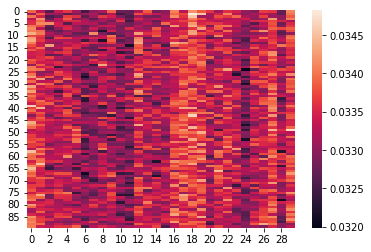

[1] loss: 0.136
tensor([[9.7255e-01, 8.0470e-04, 6.4316e-04,  ..., 2.9496e-04, 1.3598e-03,
         8.2472e-04],
        [9.9485e-01, 3.7431e-04, 1.4233e-04,  ..., 1.7652e-04, 9.7102e-05,
         9.7359e-05],
        [9.9400e-01, 1.1471e-04, 9.8309e-05,  ..., 6.4659e-05, 3.9811e-04,
         1.3951e-04],
        ...,
        [7.8698e-03, 2.1374e-03, 8.9228e-04,  ..., 9.0706e-04, 4.5930e-03,
         9.0186e-01],
        [2.5020e-03, 1.8579e-03, 9.9684e-04,  ..., 1.4728e-03, 1.1013e-03,
         9.4507e-01],
        [8.2451e-03, 2.3277e-03, 1.6756e-03,  ..., 9.3868e-04, 3.3312e-03,
         9.0809e-01]], grad_fn=<SoftmaxBackward0>)


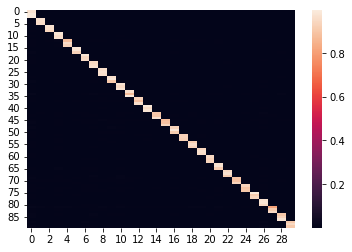

[2] loss: 0.100
tensor([[7.6955e-01, 1.0217e-03, 3.0314e-03,  ..., 1.1604e-02, 1.3293e-02,
         3.1240e-02],
        [7.9888e-01, 1.6083e-03, 1.5970e-03,  ..., 6.1976e-02, 8.3372e-04,
         6.2604e-03],
        [8.9224e-01, 1.8547e-04, 8.4646e-04,  ..., 9.7551e-03, 1.2545e-02,
         1.3511e-02],
        ...,
        [7.1104e-08, 3.4895e-07, 2.9731e-07,  ..., 4.7227e-06, 6.3317e-06,
         9.9990e-01],
        [1.8570e-08, 3.6999e-07, 5.2212e-07,  ..., 1.6503e-05, 6.3192e-07,
         9.9989e-01],
        [9.7341e-08, 4.4019e-07, 1.0303e-06,  ..., 5.2092e-06, 3.7160e-06,
         9.9988e-01]], grad_fn=<SoftmaxBackward0>)


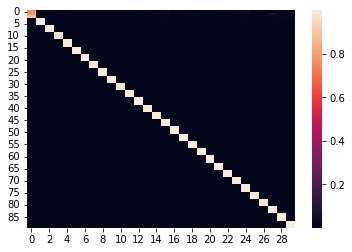

[3] loss: 0.099
tensor([[9.9920e-01, 2.9824e-06, 1.1876e-05,  ..., 3.8743e-05, 2.3074e-05,
         6.4150e-05],
        [9.9971e-01, 2.8885e-06, 3.4709e-06,  ..., 7.8021e-05, 5.5935e-07,
         5.8626e-06],
        [9.9977e-01, 2.8263e-07, 2.3533e-06,  ..., 2.1810e-05, 1.4036e-05,
         1.7461e-05],
        ...,
        [7.8374e-09, 3.1847e-09, 2.9163e-09,  ..., 6.8799e-08, 7.0643e-08,
         1.0000e+00],
        [1.7787e-09, 4.8063e-09, 9.1091e-09,  ..., 5.1854e-07, 5.0917e-09,
         1.0000e+00],
        [9.5407e-09, 3.8415e-09, 1.4015e-08,  ..., 7.1435e-08, 3.3511e-08,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


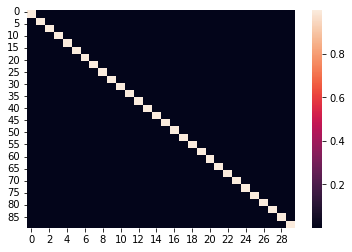

[4] loss: 0.098
tensor([[9.9999e-01, 1.9908e-08, 1.0025e-07,  ..., 2.8313e-07, 1.0003e-07,
         3.1664e-07],
        [1.0000e+00, 1.3397e-08, 1.8707e-08,  ..., 2.6559e-07, 1.1525e-09,
         1.5726e-08],
        [1.0000e+00, 1.2529e-09, 1.6961e-08,  ..., 1.2943e-07, 4.8005e-08,
         6.6616e-08],
        ...,
        [1.3114e-09, 6.8691e-11, 6.6402e-11,  ..., 2.1356e-09, 1.7881e-09,
         1.0000e+00],
        [2.6529e-10, 1.3856e-10, 3.3274e-10,  ..., 3.0239e-08, 9.8847e-11,
         1.0000e+00],
        [1.4483e-09, 7.9807e-11, 4.1677e-10,  ..., 2.1093e-09, 7.1210e-10,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


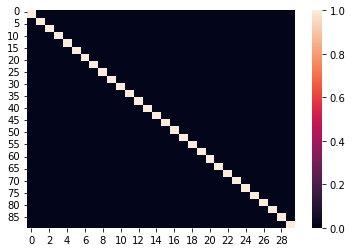

[5] loss: 0.098
tensor([[1.0000e+00, 2.8847e-10, 1.7712e-09,  ..., 4.4256e-09, 1.0063e-09,
         3.5536e-09],
        [1.0000e+00, 1.4279e-10, 2.2634e-10,  ..., 2.1775e-09, 6.1868e-12,
         1.0547e-10],
        [1.0000e+00, 1.2853e-11, 2.6235e-10,  ..., 1.6974e-09, 3.9546e-10,
         6.0170e-10],
        ...,
        [2.8948e-10, 2.6845e-12, 2.7165e-12,  ..., 1.1346e-10, 8.0001e-11,
         1.0000e+00],
        [5.3132e-11, 6.9193e-12, 2.0297e-11,  ..., 2.7370e-09, 3.5342e-12,
         1.0000e+00],
        [2.9441e-10, 3.0216e-12, 2.1366e-11,  ..., 1.0742e-10, 2.7481e-11,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


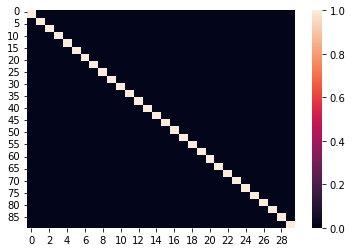

[6] loss: 0.098
tensor([[1.0000e+00, 7.5049e-12, 5.4673e-11,  ..., 1.2289e-10, 1.9117e-11,
         7.4167e-11],
        [1.0000e+00, 2.8509e-12, 5.0419e-12,  ..., 3.4669e-11, 6.8404e-14,
         1.4127e-12],
        [1.0000e+00, 2.4831e-13, 7.2218e-12,  ..., 4.0515e-11, 6.3239e-12,
         1.0416e-11],
        ...,
        [7.8730e-11, 1.6423e-13, 1.7290e-13,  ..., 9.0426e-12, 5.4994e-12,
         1.0000e+00],
        [1.3289e-11, 5.2289e-13, 1.8227e-12,  ..., 3.4529e-10, 2.0027e-13,
         1.0000e+00],
        [7.4585e-11, 1.7988e-13, 1.6517e-12,  ..., 8.2552e-12, 1.6631e-12,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


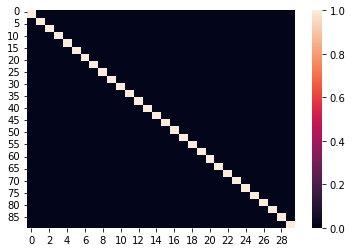

[7] loss: 0.098
tensor([[1.0000e+00, 3.1010e-13, 2.6231e-12,  ..., 5.3745e-12, 6.0022e-13,
         2.5279e-12],
        [1.0000e+00, 9.3494e-14, 1.8194e-13,  ..., 9.3280e-13, 1.3389e-15,
         3.2688e-14],
        [1.0000e+00, 7.9123e-15, 3.1352e-13,  ..., 1.5527e-12, 1.7084e-13,
         3.0152e-13],
        ...,
        [2.5254e-11, 1.4317e-14, 1.5605e-14,  ..., 9.9319e-13, 5.3086e-13,
         1.0000e+00],
        [3.9616e-12, 5.4824e-14, 2.2220e-13,  ..., 5.6635e-11, 1.6331e-14,
         1.0000e+00],
        [2.2487e-11, 1.5313e-14, 1.7667e-13,  ..., 8.7833e-13, 1.4364e-13,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


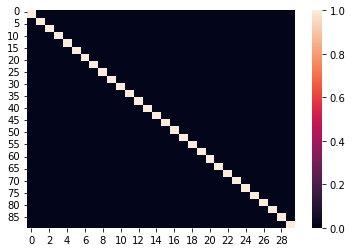

[8] loss: 0.098
tensor([[1.0000e+00, 1.8692e-14, 1.8039e-13,  ..., 3.4059e-13, 2.8401e-14,
         1.2859e-13],
        [1.0000e+00, 4.5972e-15, 9.7338e-15,  ..., 3.8519e-14, 4.1770e-17,
         1.1819e-15],
        [1.0000e+00, 3.7932e-16, 1.9743e-14,  ..., 8.7581e-14, 7.0804e-15,
         1.3281e-14],
        ...,
        [9.2688e-12, 1.6667e-15, 1.8731e-15,  ..., 1.4173e-13, 6.7607e-14,
         1.0000e+00],
        [1.3631e-12, 7.5095e-15, 3.4763e-14,  ..., 1.1509e-11, 1.7925e-15,
         1.0000e+00],
        [7.8146e-12, 1.7456e-15, 2.4629e-14,  ..., 1.2188e-13, 1.6585e-14,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


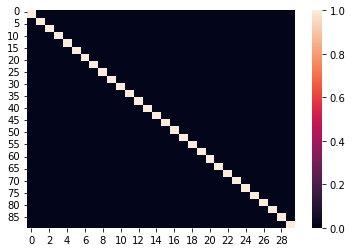

[9] loss: 0.098
tensor([[1.0000e+00, 1.5448e-15, 1.6758e-14,  ..., 2.9423e-14, 1.8932e-15,
         9.1391e-15],
        [1.0000e+00, 3.1709e-16, 7.2365e-16,  ..., 2.2750e-15, 1.9238e-18,
         6.2048e-17],
        [1.0000e+00, 2.5581e-17, 1.6962e-15,  ..., 6.8233e-15, 4.1961e-16,
         8.3078e-16],
        ...,
        [3.8072e-12, 2.4706e-16, 2.8533e-16,  ..., 2.5171e-14, 1.0853e-14,
         1.0000e+00],
        [5.2871e-13, 1.2860e-15, 6.6994e-15,  ..., 2.7973e-12, 2.5218e-16,
         1.0000e+00],
        [3.0579e-12, 2.5398e-16, 4.2846e-15,  ..., 2.1112e-14, 2.4404e-15,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


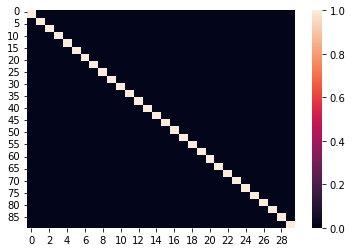

[10] loss: 0.098
tensor([[1.0000e+00, 1.6694e-16, 2.0105e-15,  ..., 3.3080e-15, 1.6889e-16,
         8.6326e-16],
        [1.0000e+00, 2.9163e-17, 7.1162e-17,  ..., 1.8216e-16, 1.2339e-19,
         4.4726e-18],
        [1.0000e+00, 2.3058e-18, 1.8979e-16,  ..., 6.9955e-16, 3.3703e-17,
         7.0021e-17],
        ...,
        [1.7209e-12, 4.4971e-17, 5.3219e-17,  ..., 5.3837e-15, 2.1213e-15,
         1.0000e+00],
        [2.2706e-13, 2.6627e-16, 1.5414e-15,  ..., 7.9165e-13, 4.3814e-17,
         1.0000e+00],
        [1.3237e-12, 4.5470e-17, 8.9974e-16,  ..., 4.4165e-15, 4.4136e-16,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


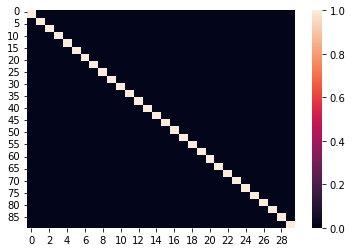

[11] loss: 0.098
tensor([[1.0000e+00, 2.2732e-17, 3.0065e-16,  ..., 4.6668e-16, 1.9365e-17,
         1.0418e-16],
        [1.0000e+00, 3.4367e-18, 8.9049e-18,  ..., 1.8958e-17, 1.0528e-20,
         4.2368e-19],
        [1.0000e+00, 2.6688e-19, 2.6663e-17,  ..., 9.0864e-17, 3.5177e-18,
         7.6305e-18],
        ...,
        [8.4469e-13, 9.7706e-18, 1.1819e-17,  ..., 1.3516e-15, 4.9126e-16,
         1.0000e+00],
        [1.0646e-13, 6.4933e-17, 4.1315e-16,  ..., 2.5544e-13, 9.1303e-18,
         1.0000e+00],
        [6.2502e-13, 9.7334e-18, 2.2220e-16,  ..., 1.0870e-15, 9.5340e-17,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


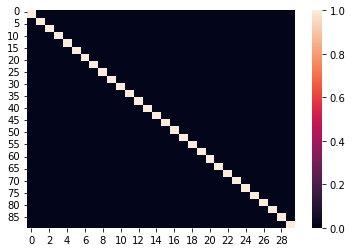

[12] loss: 0.098
tensor([[1.0000e+00, 3.7854e-18, 5.4466e-17,  ..., 8.0224e-17, 2.7630e-18,
         1.5564e-17],
        [1.0000e+00, 5.0255e-19, 1.3744e-18,  ..., 2.4790e-18, 1.1515e-21,
         5.0911e-20],
        [1.0000e+00, 3.8398e-20, 4.5666e-18,  ..., 1.4502e-17, 4.6122e-19,
         1.0400e-18],
        ...,
        [4.4548e-13, 2.4765e-18, 3.0554e-18,  ..., 3.9013e-16, 1.3187e-16,
         1.0000e+00],
        [5.3876e-14, 1.8258e-17, 1.2648e-16,  ..., 9.2389e-14, 2.2290e-18,
         1.0000e+00],
        [3.1834e-13, 2.4343e-18, 6.3198e-17,  ..., 3.0817e-16, 2.4040e-17,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


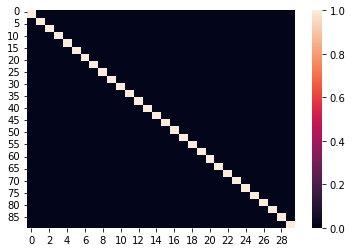

[13] loss: 0.098
tensor([[1.0000e+00, 7.5218e-19, 1.1677e-17,  ..., 1.6404e-17, 4.7762e-19,
         2.8043e-18],
        [1.0000e+00, 8.8823e-20, 2.5505e-19,  ..., 3.9610e-19, 1.5665e-22,
         7.5381e-21],
        [1.0000e+00, 6.6882e-21, 9.3074e-19,  ..., 2.7732e-18, 7.3878e-20,
         1.7250e-19],
        ...,
        [2.5023e-13, 7.1861e-19, 9.0256e-19,  ..., 1.2728e-16, 4.0298e-17,
         1.0000e+00],
        [2.9158e-14, 5.8179e-18, 4.3515e-17,  ..., 3.6940e-14, 6.2534e-19,
         1.0000e+00],
        [1.7328e-13, 6.9792e-19, 2.0347e-17,  ..., 9.8932e-17, 6.9435e-18,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


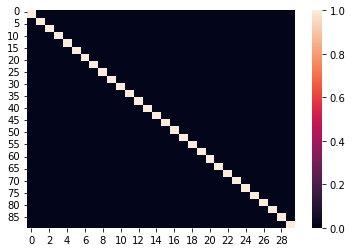

[14] loss: 0.098
tensor([[1.0000e+00, 1.7472e-19, 2.9052e-18,  ..., 3.9101e-18, 9.7823e-20,
         5.9624e-19],
        [1.0000e+00, 1.8561e-20, 5.5698e-20,  ..., 7.5558e-20, 2.5842e-23,
         1.3424e-21],
        [1.0000e+00, 1.3793e-21, 2.2122e-19,  ..., 6.2224e-19, 1.4125e-20,
         3.4037e-20],
        ...,
        [1.4861e-13, 2.3501e-19, 2.9997e-19,  ..., 4.6271e-17, 1.3810e-17,
         1.0000e+00],
        [1.6745e-14, 2.0705e-18, 1.6597e-17,  ..., 1.6138e-14, 1.9837e-19,
         1.0000e+00],
        [1.0003e-13, 2.2578e-19, 7.3091e-18,  ..., 3.5446e-17, 2.2613e-18,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


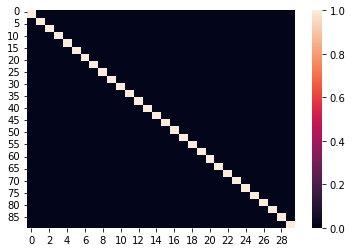

[15] loss: 0.098
tensor([[1.0000e+00, 4.6629e-20, 8.2505e-19,  ..., 1.0682e-18, 2.3296e-20,
         1.4687e-19],
        [1.0000e+00, 4.5014e-21, 1.4057e-20,  ..., 1.6871e-20, 5.0598e-24,
         2.8168e-22],
        [1.0000e+00, 3.3052e-22, 6.0282e-20,  ..., 1.6093e-19, 3.1607e-21,
         7.8364e-21],
        ...,
        [9.2742e-14, 8.5473e-20, 1.1071e-19,  ..., 1.8520e-17, 5.2397e-18,
         1.0000e+00],
        [1.0137e-14, 8.1290e-19, 6.9384e-18,  ..., 7.6276e-15, 7.0184e-20,
         1.0000e+00],
        [6.0843e-14, 8.1312e-20, 2.8942e-18,  ..., 1.4002e-17, 8.1933e-19,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


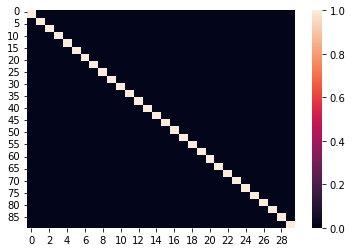

[16] loss: 0.098
tensor([[1.0000e+00, 1.4085e-20, 2.6368e-19,  ..., 3.2957e-19, 6.3470e-21,
         4.1260e-20],
        [1.0000e+00, 1.2468e-21, 4.0368e-21,  ..., 4.3359e-21, 1.1544e-24,
         6.8426e-23],
        [1.0000e+00, 9.0561e-23, 1.8557e-20,  ..., 4.7251e-20, 8.1388e-22,
         2.0707e-21],
        ...,
        [6.0492e-14, 3.4181e-20, 4.4865e-20,  ..., 8.0778e-18, 2.1773e-18,
         1.0000e+00],
        [6.4321e-15, 3.4841e-19, 3.1479e-18,  ..., 3.8678e-15, 2.7374e-20,
         1.0000e+00],
        [3.8773e-14, 3.2228e-20, 1.2501e-18,  ..., 6.0345e-18, 3.2654e-19,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


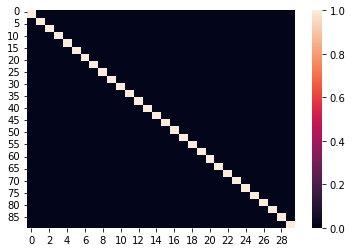

[17] loss: 0.098
tensor([[1.0000e+00, 4.7545e-21, 9.3675e-20,  ..., 1.1340e-19, 1.9509e-21,
         1.3039e-20],
        [1.0000e+00, 3.8901e-22, 1.3016e-21,  ..., 1.2639e-21, 3.0209e-25,
         1.8954e-23],
        [1.0000e+00, 2.7980e-23, 6.3726e-21,  ..., 1.5543e-20, 2.3768e-22,
         6.1903e-22],
        ...,
        [4.1052e-14, 1.4882e-20, 1.9771e-20,  ..., 3.8051e-18, 9.8154e-19,
         1.0000e+00],
        [4.2572e-15, 1.6154e-19, 1.5368e-18,  ..., 2.0888e-15, 1.1651e-20,
         1.0000e+00],
        [2.5762e-14, 1.3919e-20, 5.8368e-19,  ..., 2.8119e-18, 1.4173e-19,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


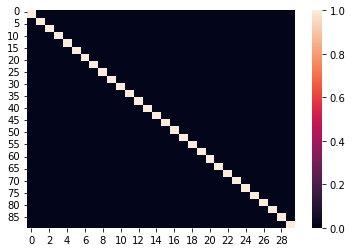

[18] loss: 0.098
tensor([[1.0000e+00, 1.7734e-21, 3.6601e-20,  ..., 4.3040e-20, 6.6832e-22,
         4.5810e-21],
        [1.0000e+00, 1.3509e-22, 4.6567e-22,  ..., 4.1263e-22, 8.9415e-26,
         5.9075e-24],
        [1.0000e+00, 9.6299e-24, 2.4143e-21,  ..., 5.6631e-21, 7.7726e-23,
         2.0678e-22],
        ...,
        [2.8869e-14, 6.9938e-21, 9.3943e-21,  ..., 1.9208e-18, 4.7610e-19,
         1.0000e+00],
        [2.9266e-15, 8.0379e-20, 8.0142e-19,  ..., 1.1938e-15, 5.3642e-21,
         1.0000e+00],
        [1.7773e-14, 6.4936e-21, 2.9230e-19,  ..., 1.4056e-18, 6.6422e-20,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


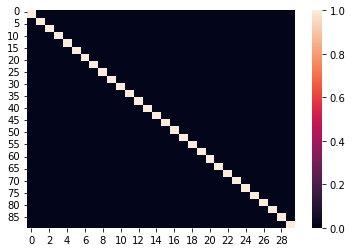

[19] loss: 0.098
tensor([[1.0000e+00, 7.2369e-22, 1.5581e-20,  ..., 1.7844e-20, 2.5245e-22,
         1.7704e-21],
        [1.0000e+00, 5.1663e-23, 1.8298e-22,  ..., 1.4918e-22, 2.9574e-26,
         2.0478e-24],
        [1.0000e+00, 3.6531e-24, 9.9938e-22,  ..., 2.2623e-21, 2.8145e-23,
         7.6335e-23],
        ...,
        [2.0964e-14, 3.5212e-21, 4.7774e-21,  ..., 1.0320e-18, 2.4669e-19,
         1.0000e+00],
        [2.0818e-15, 4.2625e-20, 4.4350e-19,  ..., 7.1799e-16, 2.6507e-21,
         1.0000e+00],
        [1.2683e-14, 3.2476e-21, 1.5591e-19,  ..., 7.4846e-19, 3.3357e-20,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


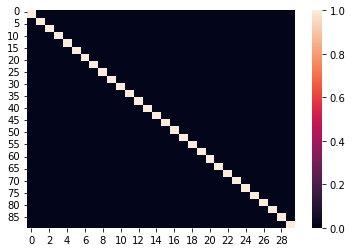

[20] loss: 0.098
tensor([[1.0000e+00, 3.2032e-22, 7.1666e-21,  ..., 8.0124e-21, 1.0415e-22,
         7.4580e-22],
        [1.0000e+00, 2.1557e-23, 7.8258e-23,  ..., 5.9146e-23, 1.0814e-26,
         7.8140e-25],
        [1.0000e+00, 1.5130e-24, 4.4812e-22,  ..., 9.8212e-22, 1.1175e-23,
         3.0843e-23],
        ...,
        [1.5671e-14, 1.8866e-21, 2.5831e-21,  ..., 5.8659e-19, 1.3567e-19,
         1.0000e+00],
        [1.5273e-15, 2.3941e-20, 2.5895e-19,  ..., 4.5219e-16, 1.3963e-21,
         1.0000e+00],
        [9.3324e-15, 1.7295e-21, 8.8037e-20,  ..., 4.2198e-19, 1.7831e-20,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


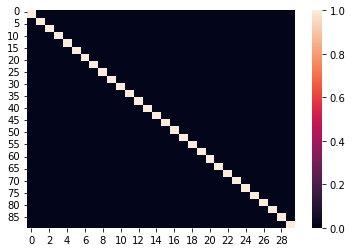

[21] loss: 0.098
tensor([[1.0000e+00, 1.5260e-22, 3.5355e-21,  ..., 3.8672e-21, 4.6543e-23,
         3.3964e-22],
        [1.0000e+00, 9.7322e-24, 3.6134e-23,  ..., 2.5489e-23, 4.3295e-27,
         3.2523e-25],
        [1.0000e+00, 6.7852e-25, 2.1601e-22,  ..., 4.5968e-22, 4.8222e-24,
         1.3524e-23],
        ...,
        [1.2026e-14, 1.0693e-21, 1.4763e-21,  ..., 3.5085e-19, 7.8752e-20,
         1.0000e+00],
        [1.1522e-15, 1.4165e-20, 1.5872e-19,  ..., 2.9692e-16, 7.7931e-22,
         1.0000e+00],
        [7.0592e-15, 9.7490e-22, 5.2342e-20,  ..., 2.5053e-19, 1.0086e-20,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


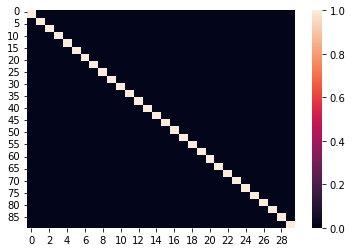

[22] loss: 0.098
tensor([[1.0000e+00, 7.7702e-23, 1.8585e-21,  ..., 1.9927e-21, 2.2359e-23,
         1.6599e-22],
        [1.0000e+00, 4.7192e-24, 1.7883e-23,  ..., 1.1847e-23, 1.8820e-27,
         1.4645e-25],
        [1.0000e+00, 3.2701e-25, 1.1118e-22,  ..., 2.3033e-22, 2.2441e-24,
         6.3853e-24],
        ...,
        [9.4512e-15, 6.3780e-22, 8.8724e-22,  ..., 2.1976e-19, 4.8000e-20,
         1.0000e+00],
        [8.9149e-16, 8.7858e-21, 1.0166e-19,  ..., 2.0247e-16, 4.5834e-22,
         1.0000e+00],
        [5.4753e-15, 5.7858e-22, 3.2608e-20,  ..., 1.5587e-19, 6.0043e-21,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


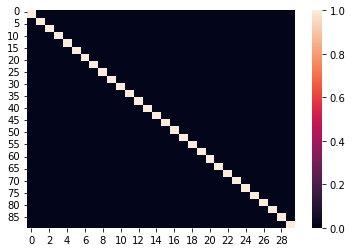

[23] loss: 0.098
tensor([[1.0000e+00, 4.2030e-23, 1.0349e-21,  ..., 1.0896e-21, 1.1470e-23,
         8.6496e-23],
        [1.0000e+00, 2.4416e-24, 9.4263e-24,  ..., 5.8971e-24, 8.8141e-28,
         7.0831e-26],
        [1.0000e+00, 1.6824e-25, 6.0732e-23,  ..., 1.2278e-22, 1.1183e-24,
         3.2244e-24],
        ...,
        [7.5893e-15, 3.9843e-22, 5.5809e-22,  ..., 1.4354e-19, 3.0583e-20,
         1.0000e+00],
        [7.0581e-16, 5.6873e-21, 6.7762e-20,  ..., 1.4288e-16, 2.8269e-22,
         1.0000e+00],
        [4.3445e-15, 3.5979e-22, 2.1194e-20,  ..., 1.0119e-19, 3.7445e-21,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


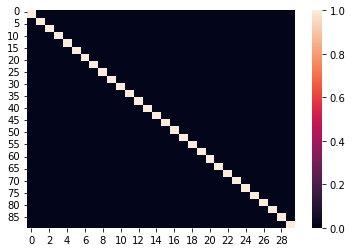

[24] loss: 0.098
tensor([[1.0000e+00, 2.4017e-23, 6.0719e-22,  ..., 6.2877e-22, 6.2455e-24,
         4.7773e-23],
        [1.0000e+00, 1.3398e-24, 5.2611e-24,  ..., 3.1241e-24, 4.4174e-28,
         3.6553e-26],
        [1.0000e+00, 9.1855e-26, 3.5016e-23,  ..., 6.9230e-23, 5.9309e-25,
         1.7307e-24],
        ...,
        [6.2149e-15, 2.5958e-22, 3.6591e-22,  ..., 9.7391e-20, 2.0286e-20,
         1.0000e+00],
        [5.7057e-16, 3.8274e-21, 4.6834e-20,  ..., 1.0402e-16, 1.8204e-22,
         1.0000e+00],
        [3.5192e-15, 2.3344e-22, 1.4315e-20,  ..., 6.8273e-20, 2.4358e-21,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


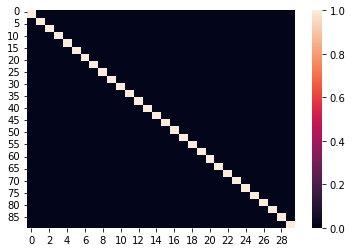

[25] loss: 0.098
tensor([[1.0000e+00, 1.4426e-23, 3.7360e-22,  ..., 3.8107e-22, 3.5900e-24,
         2.7819e-23],
        [1.0000e+00, 7.7559e-25, 3.0931e-24,  ..., 1.7515e-24, 2.3546e-28,
         2.0009e-26],
        [1.0000e+00, 5.2929e-26, 2.1205e-23,  ..., 4.1081e-23, 3.3283e-25,
         9.8192e-25],
        ...,
        [5.1808e-15, 1.7571e-22, 2.4910e-22,  ..., 6.8404e-20, 1.3958e-20,
         1.0000e+00],
        [4.7008e-16, 2.6683e-21, 3.3454e-20,  ..., 7.7901e-17, 1.2192e-22,
         1.0000e+00],
        [2.9047e-15, 1.5741e-22, 1.0014e-20,  ..., 4.7709e-20, 1.6464e-21,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


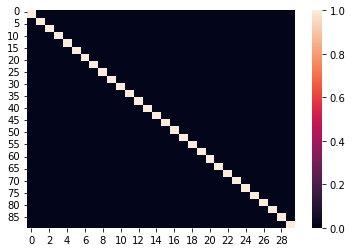

[26] loss: 0.098
tensor([[1.0000e+00, 9.0675e-24, 2.4003e-22,  ..., 2.4148e-22, 2.1679e-24,
         1.6999e-23],
        [1.0000e+00, 4.7138e-25, 1.9066e-24,  ..., 1.0338e-24, 1.3273e-28,
         1.1557e-26],
        [1.0000e+00, 3.2034e-26, 1.3428e-23,  ..., 2.5537e-23, 1.9664e-25,
         5.8593e-25],
        ...,
        [4.3892e-15, 1.2314e-22, 1.7549e-22,  ..., 4.9580e-20, 9.9288e-21,
         1.0000e+00],
        [3.9402e-16, 1.9210e-21, 2.4623e-20,  ..., 5.9862e-17, 8.4625e-23,
         1.0000e+00],
        [2.4388e-15, 1.0994e-22, 7.2311e-21,  ..., 3.4420e-20, 1.1523e-21,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


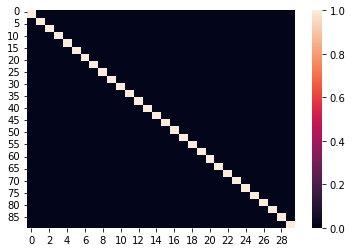

[27] loss: 0.098
tensor([[1.0000e+00, 5.9398e-24, 1.6041e-22,  ..., 1.5936e-22, 1.3692e-24,
         1.0852e-23],
        [1.0000e+00, 2.9947e-25, 1.2269e-24,  ..., 6.3954e-25, 7.8740e-29,
         7.0092e-27],
        [1.0000e+00, 2.0273e-26, 8.8560e-24,  ..., 1.6560e-23, 1.2174e-25,
         3.6607e-25],
        ...,
        [3.7739e-15, 8.9069e-23, 1.2755e-22,  ..., 3.6980e-20, 7.2801e-21,
         1.0000e+00],
        [3.3549e-16, 1.4239e-21, 1.8624e-20,  ..., 4.7091e-17, 6.0675e-23,
         1.0000e+00],
        [2.0797e-15, 7.9273e-23, 5.3753e-21,  ..., 2.5565e-20, 8.3253e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


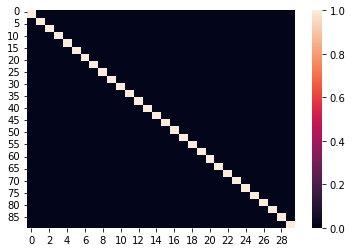

[28] loss: 0.098
tensor([[1.0000e+00, 4.0400e-24, 1.1111e-22,  ..., 1.0913e-22, 9.0084e-25,
         7.2102e-24],
        [1.0000e+00, 1.9808e-25, 8.2111e-25,  ..., 4.1288e-25, 4.8930e-29,
         4.4442e-27],
        [1.0000e+00, 1.3363e-26, 6.0610e-24,  ..., 1.1161e-23, 7.8657e-26,
         2.3847e-25],
        ...,
        [3.2887e-15, 6.6309e-23, 9.5369e-23,  ..., 2.8311e-20, 5.4873e-21,
         1.0000e+00],
        [2.8976e-16, 1.0840e-21, 1.4441e-20,  ..., 3.7843e-17, 4.4811e-23,
         1.0000e+00],
        [1.7988e-15, 5.8848e-23, 4.1025e-21,  ..., 1.9497e-20, 6.1913e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


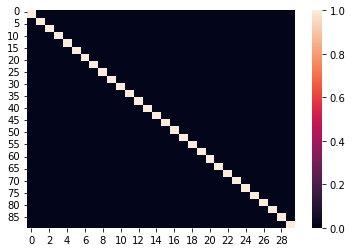

[29] loss: 0.098
tensor([[1.0000e+00, 2.8437e-24, 7.9517e-23,  ..., 7.7287e-23, 6.1516e-25,
         4.9677e-24],
        [1.0000e+00, 1.3593e-25, 5.6950e-25,  ..., 2.7712e-25, 3.1720e-29,
         2.9344e-27],
        [1.0000e+00, 9.1405e-27, 4.2904e-24,  ..., 7.7901e-24, 5.2833e-26,
         1.6139e-25],
        ...,
        [2.9011e-15, 5.0677e-23, 7.3177e-23,  ..., 2.2195e-20, 4.2413e-21,
         1.0000e+00],
        [2.5356e-16, 8.4548e-22, 1.1454e-20,  ..., 3.1009e-17, 3.3999e-23,
         1.0000e+00],
        [1.5760e-15, 4.4858e-23, 3.2073e-21,  ..., 1.5231e-20, 4.7272e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


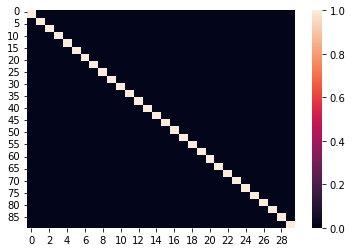

[30] loss: 0.098
tensor([[1.0000e+00, 2.0651e-24, 5.8626e-23,  ..., 5.6442e-23, 4.3457e-25,
         3.5380e-24],
        [1.0000e+00, 9.6452e-26, 4.0806e-25,  ..., 1.9271e-25, 2.1371e-29,
         2.0103e-27],
        [1.0000e+00, 6.4671e-27, 3.1318e-24,  ..., 5.6142e-24, 3.6765e-26,
         1.1308e-25],
        ...,
        [2.5879e-15, 3.9667e-23, 5.7488e-23,  ..., 1.7781e-20, 3.3541e-21,
         1.0000e+00],
        [2.2452e-16, 6.7417e-22, 9.2738e-21,  ..., 2.5862e-17, 2.6436e-23,
         1.0000e+00],
        [1.3972e-15, 3.5030e-23, 2.5629e-21,  ..., 1.2163e-20, 3.6970e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


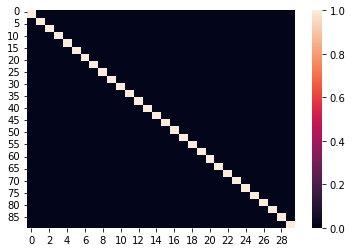

[31] loss: 0.098
tensor([[1.0000e+00, 1.5430e-24, 4.4412e-23,  ..., 4.2387e-23, 3.1664e-25,
         2.5970e-24],
        [1.0000e+00, 7.0561e-26, 3.0118e-25,  ..., 1.3842e-25, 1.4913e-29,
         1.4244e-27],
        [1.0000e+00, 4.7187e-27, 2.3510e-24,  ..., 4.1656e-24, 2.6422e-26,
         8.1775e-26],
        ...,
        [2.3321e-15, 3.1734e-23, 4.6143e-23,  ..., 1.4528e-20, 2.7086e-21,
         1.0000e+00],
        [2.0097e-16, 5.4852e-22, 7.6510e-21,  ..., 2.1921e-17, 2.1021e-23,
         1.0000e+00],
        [1.2520e-15, 2.7963e-23, 2.0893e-21,  ..., 9.9097e-21, 2.9552e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


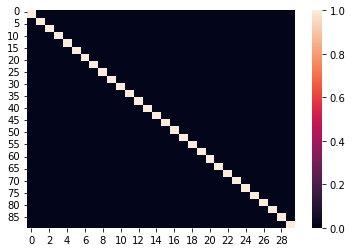

[32] loss: 0.098
tensor([[1.0000e+00, 1.1832e-24, 3.4486e-23,  ..., 3.2654e-23, 2.3730e-25,
         1.9594e-24],
        [1.0000e+00, 5.3078e-26, 2.2839e-25,  ..., 1.0239e-25, 1.0746e-29,
         1.0407e-27],
        [1.0000e+00, 3.5409e-27, 1.8105e-24,  ..., 3.1741e-24, 1.9556e-26,
         6.0869e-26],
        ...,
        [2.1212e-15, 2.5896e-23, 3.7769e-23,  ..., 1.2086e-20, 2.2293e-21,
         1.0000e+00],
        [1.8168e-16, 4.5456e-22, 6.4213e-21,  ..., 1.8857e-17, 1.7060e-23,
         1.0000e+00],
        [1.1328e-15, 2.2774e-23, 1.7345e-21,  ..., 8.2221e-21, 2.4098e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


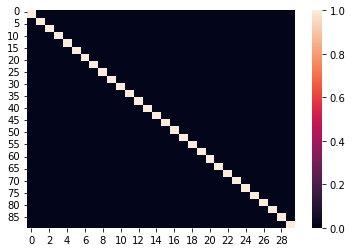

[33] loss: 0.098
tensor([[1.0000e+00, 9.2900e-25, 2.7389e-23,  ..., 2.5748e-23, 1.8247e-25,
         1.5160e-24],
        [1.0000e+00, 4.0952e-26, 1.7752e-25,  ..., 7.7801e-26, 7.9724e-30,
         7.8189e-28],
        [1.0000e+00, 2.7260e-27, 1.4271e-24,  ..., 2.4778e-24, 1.4867e-26,
         4.6515e-26],
        ...,
        [1.9456e-15, 2.1519e-23, 3.1471e-23,  ..., 1.0221e-20, 1.8669e-21,
         1.0000e+00],
        [1.6571e-16, 3.8304e-22, 5.4740e-21,  ..., 1.6439e-17, 1.4105e-23,
         1.0000e+00],
        [1.0342e-15, 1.8891e-23, 1.4640e-21,  ..., 6.9364e-21, 2.0012e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


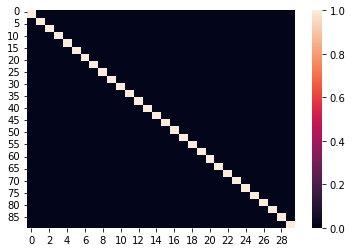

[34] loss: 0.098
tensor([[1.0000e+00, 7.4532e-25, 2.2204e-23,  ..., 2.0737e-23, 1.4364e-25,
         1.2000e-24],
        [1.0000e+00, 3.2336e-26, 1.4111e-25,  ..., 6.0582e-26, 6.0743e-30,
         6.0262e-28],
        [1.0000e+00, 2.1481e-27, 1.1491e-24,  ..., 1.9774e-24, 1.1583e-26,
         3.6409e-26],
        ...,
        [1.7985e-15, 1.8179e-23, 2.6654e-23,  ..., 8.7738e-21, 1.5884e-21,
         1.0000e+00],
        [1.5240e-16, 3.2775e-22, 4.7334e-21,  ..., 1.4508e-17, 1.1862e-23,
         1.0000e+00],
        [9.5190e-16, 1.5933e-23, 1.2545e-21,  ..., 5.9412e-21, 1.6896e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


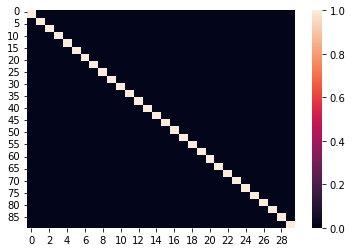

[35] loss: 0.098
tensor([[1.0000e+00, 6.0984e-25, 1.8341e-23,  ..., 1.7027e-23, 1.1551e-25,
         9.6994e-25],
        [1.0000e+00, 2.6076e-26, 1.1449e-25,  ..., 4.8240e-26, 4.7418e-30,
         4.7538e-28],
        [1.0000e+00, 1.7292e-27, 9.4324e-25,  ..., 1.6102e-24, 9.2270e-27,
         2.9129e-26],
        ...,
        [1.6741e-15, 1.5590e-23, 2.2911e-23,  ..., 7.6347e-21, 1.3710e-21,
         1.0000e+00],
        [1.4121e-16, 2.8437e-22, 4.1464e-21,  ..., 1.2948e-17, 1.0131e-23,
         1.0000e+00],
        [8.8264e-16, 1.3644e-23, 1.0899e-21,  ..., 5.1596e-21, 1.4482e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


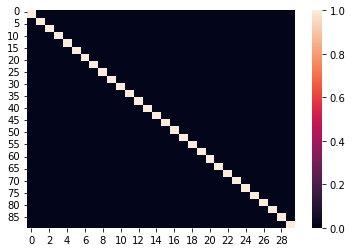

[36] loss: 0.098
tensor([[1.0000e+00, 5.0801e-25, 1.5411e-23,  ..., 1.4229e-23, 9.4719e-26,
         7.9904e-25],
        [1.0000e+00, 2.1437e-26, 9.4651e-26,  ..., 3.9202e-26, 3.7845e-30,
         3.8304e-28],
        [1.0000e+00, 1.4192e-27, 7.8808e-25,  ..., 1.3355e-24, 7.5013e-27,
         2.3774e-26],
        ...,
        [1.5684e-15, 1.3555e-23, 1.9962e-23,  ..., 6.7267e-21, 1.1991e-21,
         1.0000e+00],
        [1.3173e-16, 2.4988e-22, 3.6755e-21,  ..., 1.1673e-17, 8.7753e-24,
         1.0000e+00],
        [8.2396e-16, 1.1847e-23, 9.5891e-22,  ..., 4.5377e-21, 1.2586e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


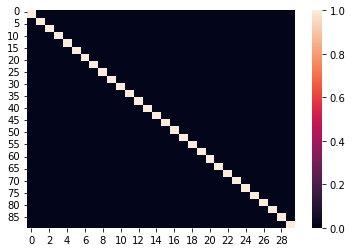

[37] loss: 0.098
tensor([[1.0000e+00, 4.3016e-25, 1.3153e-23,  ..., 1.2083e-23, 7.9061e-26,
         6.6976e-25],
        [1.0000e+00, 1.7935e-26, 7.9590e-26,  ..., 3.2454e-26, 3.0820e-30,
         3.1466e-28],
        [1.0000e+00, 1.1855e-27, 6.6912e-25,  ..., 1.1264e-24, 6.2124e-27,
         1.9759e-26],
        ...,
        [1.4779e-15, 1.1935e-23, 1.7608e-23,  ..., 5.9943e-21, 1.0614e-21,
         1.0000e+00],
        [1.2366e-16, 2.2213e-22, 3.2934e-21,  ..., 1.0622e-17, 7.6994e-24,
         1.0000e+00],
        [7.7392e-16, 1.0418e-23, 8.5338e-22,  ..., 4.0368e-21, 1.1076e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


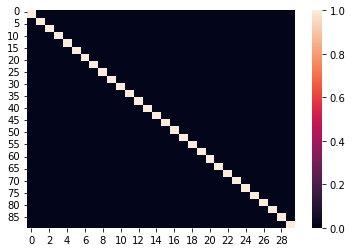

[38] loss: 0.098
tensor([[1.0000e+00, 3.6971e-25, 1.1386e-23,  ..., 1.0413e-23, 6.7069e-26,
         5.7035e-25],
        [1.0000e+00, 1.5246e-26, 6.7973e-26,  ..., 2.7327e-26, 2.5566e-30,
         2.6308e-28],
        [1.0000e+00, 1.0064e-27, 5.7650e-25,  ..., 9.6457e-25, 5.2326e-27,
         1.6696e-26],
        ...,
        [1.4001e-15, 1.0628e-23, 1.5708e-23,  ..., 5.3970e-21, 9.4978e-22,
         1.0000e+00],
        [1.1674e-16, 1.9955e-22, 2.9802e-21,  ..., 9.7479e-18, 6.8350e-24,
         1.0000e+00],
        [7.3102e-16, 9.2668e-24, 7.6744e-22,  ..., 3.6291e-21, 9.8591e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


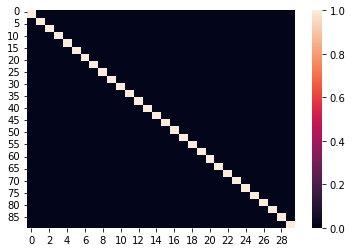

[39] loss: 0.098
tensor([[1.0000e+00, 3.2210e-25, 9.9848e-24,  ..., 9.0939e-24, 5.7741e-26,
         4.9274e-25],
        [1.0000e+00, 1.3151e-26, 5.8880e-26,  ..., 2.3367e-26, 2.1565e-30,
         2.2352e-28],
        [1.0000e+00, 8.6705e-28, 5.0339e-25,  ..., 8.3760e-25, 4.4758e-27,
         1.4324e-26],
        ...,
        [1.3328e-15, 9.5635e-24, 1.4157e-23,  ..., 4.9052e-21, 8.5845e-22,
         1.0000e+00],
        [1.1078e-16, 1.8101e-22, 2.7211e-21,  ..., 9.0148e-18, 6.1330e-24,
         1.0000e+00],
        [6.9404e-16, 8.3302e-24, 6.9676e-22,  ..., 3.2939e-21, 8.8683e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


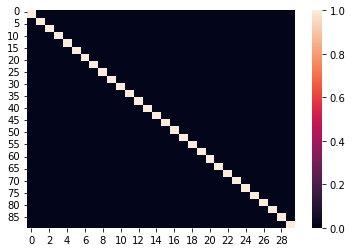

[40] loss: 0.098
tensor([[1.0000e+00, 2.8412e-25, 8.8601e-24,  ..., 8.0392e-24, 5.0384e-26,
         4.3132e-25],
        [1.0000e+00, 1.1496e-26, 5.1666e-26,  ..., 2.0264e-26, 1.8471e-30,
         1.9271e-28],
        [1.0000e+00, 7.5704e-28, 4.4495e-25,  ..., 7.3662e-25, 3.8826e-27,
         1.2458e-26],
        ...,
        [1.2744e-15, 8.6877e-24, 1.2879e-23,  ..., 4.4967e-21, 7.8298e-22,
         1.0000e+00],
        [1.0562e-16, 1.6563e-22, 2.5049e-21,  ..., 8.3956e-18, 5.5568e-24,
         1.0000e+00],
        [6.6201e-16, 7.5602e-24, 6.3811e-22,  ..., 3.0158e-21, 8.0534e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


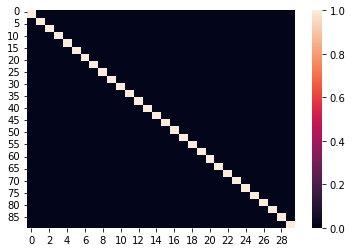

[41] loss: 0.098
tensor([[1.0000e+00, 2.5347e-25, 7.9469e-24,  ..., 7.1860e-24, 4.4507e-26,
         3.8211e-25],
        [1.0000e+00, 1.0171e-26, 4.5872e-26,  ..., 1.7799e-26, 1.6043e-30,
         1.6838e-28],
        [1.0000e+00, 6.6911e-28, 3.9768e-25,  ..., 6.5534e-25, 3.4113e-27,
         1.0973e-26],
        ...,
        [1.2235e-15, 7.9605e-24, 1.1817e-23,  ..., 4.1546e-21, 7.2009e-22,
         1.0000e+00],
        [1.0113e-16, 1.5277e-22, 2.3232e-21,  ..., 7.8691e-18, 5.0797e-24,
         1.0000e+00],
        [6.3415e-16, 6.9216e-24, 5.8903e-22,  ..., 2.7832e-21, 7.3770e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


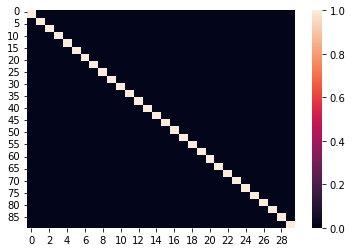

[42] loss: 0.098
tensor([[1.0000e+00, 2.2846e-25, 7.1983e-24,  ..., 6.4888e-24, 3.9758e-26,
         3.4224e-25],
        [1.0000e+00, 9.0989e-27, 4.1167e-26,  ..., 1.5819e-26, 1.4113e-30,
         1.4892e-28],
        [1.0000e+00, 5.9801e-28, 3.5905e-25,  ..., 5.8921e-25, 3.0324e-27,
         9.7758e-27],
        ...,
        [1.1789e-15, 7.3519e-24, 1.0926e-23,  ..., 3.8660e-21, 6.6727e-22,
         1.0000e+00],
        [9.7212e-17, 1.4194e-22, 2.1693e-21,  ..., 7.4189e-18, 4.6813e-24,
         1.0000e+00],
        [6.0982e-16, 6.3875e-24, 5.4767e-22,  ..., 2.5872e-21, 6.8111e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


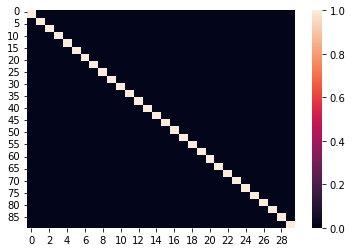

[43] loss: 0.098
tensor([[1.0000e+00, 2.0786e-25, 6.5786e-24,  ..., 5.9133e-24, 3.5879e-26,
         3.0958e-25],
        [1.0000e+00, 8.2220e-27, 3.7307e-26,  ..., 1.4209e-26, 1.2559e-30,
         1.3318e-28],
        [1.0000e+00, 5.3991e-28, 3.2717e-25,  ..., 5.3486e-25, 2.7244e-27,
         8.8004e-27],
        ...,
        [1.1398e-15, 6.8388e-24, 1.0175e-23,  ..., 3.6209e-21, 6.2258e-22,
         1.0000e+00],
        [9.3779e-17, 1.3276e-22, 2.0381e-21,  ..., 7.0316e-18, 4.3460e-24,
         1.0000e+00],
        [5.8850e-16, 5.9376e-24, 5.1257e-22,  ..., 2.4209e-21, 6.3342e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


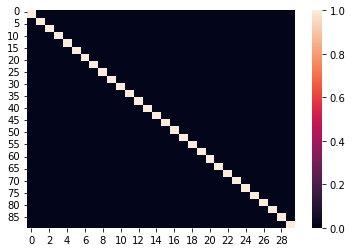

[44] loss: 0.098
tensor([[1.0000e+00, 1.9074e-25, 6.0614e-24,  ..., 5.4343e-24, 3.2680e-26,
         2.8259e-25],
        [1.0000e+00, 7.4981e-27, 3.4111e-26,  ..., 1.2887e-26, 1.1294e-30,
         1.2031e-28],
        [1.0000e+00, 4.9198e-28, 3.0065e-25,  ..., 4.8980e-25, 2.4715e-27,
         7.9981e-27],
        ...,
        [1.1053e-15, 6.4032e-24, 9.5362e-24,  ..., 3.4115e-21, 5.8454e-22,
         1.0000e+00],
        [9.0764e-17, 1.2493e-22, 1.9258e-21,  ..., 6.6970e-18, 4.0620e-24,
         1.0000e+00],
        [5.6975e-16, 5.5558e-24, 4.8260e-22,  ..., 2.2789e-21, 5.9294e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


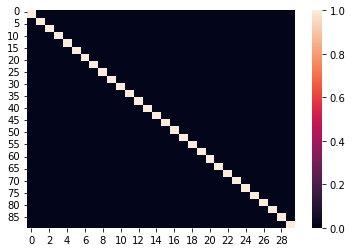

[45] loss: 0.098
tensor([[1.0000e+00, 1.7639e-25, 5.6264e-24,  ..., 5.0325e-24, 3.0019e-26,
         2.6010e-25],
        [1.0000e+00, 6.8951e-27, 3.1443e-26,  ..., 1.1792e-26, 1.0256e-30,
         1.0969e-28],
        [1.0000e+00, 4.5209e-28, 2.7839e-25,  ..., 4.5211e-25, 2.2619e-27,
         7.3321e-27],
        ...,
        [1.0749e-15, 6.0312e-24, 8.9902e-24,  ..., 3.2315e-21, 5.5197e-22,
         1.0000e+00],
        [8.8105e-17, 1.1820e-22, 1.8290e-21,  ..., 6.4066e-18, 3.8198e-24,
         1.0000e+00],
        [5.5322e-16, 5.2300e-24, 4.5687e-22,  ..., 2.1570e-21, 5.5837e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


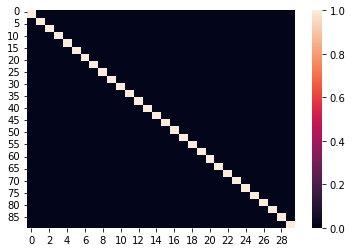

[46] loss: 0.098
tensor([[1.0000e+00, 1.6429e-25, 5.2580e-24,  ..., 4.6929e-24, 2.7788e-26,
         2.4120e-25],
        [1.0000e+00, 6.3890e-27, 2.9199e-26,  ..., 1.0877e-26, 9.3939e-31,
         1.0084e-28],
        [1.0000e+00, 4.1864e-28, 2.5959e-25,  ..., 4.2037e-25, 2.0868e-27,
         6.7747e-27],
        ...,
        [1.0479e-15, 5.7116e-24, 8.5209e-24,  ..., 3.0762e-21, 5.2392e-22,
         1.0000e+00],
        [8.5754e-17, 1.1240e-22, 1.7451e-21,  ..., 6.1533e-18, 3.6122e-24,
         1.0000e+00],
        [5.3860e-16, 4.9504e-24, 4.3466e-22,  ..., 2.0519e-21, 5.2869e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


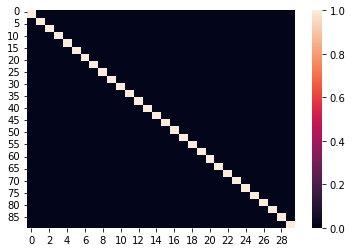

[47] loss: 0.098
tensor([[1.0000e+00, 1.5400e-25, 4.9440e-24,  ..., 4.4041e-24, 2.5904e-26,
         2.2521e-25],
        [1.0000e+00, 5.9611e-27, 2.7297e-26,  ..., 1.0107e-26, 8.6735e-31,
         9.3425e-29],
        [1.0000e+00, 3.9038e-28, 2.4360e-25,  ..., 3.9344e-25, 1.9394e-27,
         6.3049e-27],
        ...,
        [1.0240e-15, 5.4359e-24, 8.1157e-24,  ..., 2.9414e-21, 4.9967e-22,
         1.0000e+00],
        [8.3672e-17, 1.0738e-22, 1.6723e-21,  ..., 5.9319e-18, 3.4332e-24,
         1.0000e+00],
        [5.2565e-16, 4.7091e-24, 4.1541e-22,  ..., 1.9607e-21, 5.0308e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


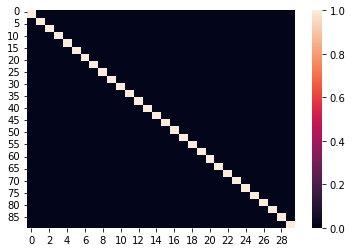

[48] loss: 0.098
tensor([[1.0000e+00, 1.4521e-25, 4.6749e-24,  ..., 4.1570e-24, 2.4302e-26,
         2.1159e-25],
        [1.0000e+00, 5.5971e-27, 2.5676e-26,  ..., 9.4547e-27, 8.0666e-31,
         8.7154e-29],
        [1.0000e+00, 3.6634e-28, 2.2992e-25,  ..., 3.7047e-25, 1.8145e-27,
         5.9060e-27],
        ...,
        [1.0028e-15, 5.1967e-24, 7.7639e-24,  ..., 2.8240e-21, 4.7860e-22,
         1.0000e+00],
        [8.1823e-17, 1.0300e-22, 1.6087e-21,  ..., 5.7374e-18, 3.2782e-24,
         1.0000e+00],
        [5.1414e-16, 4.5000e-24, 3.9865e-22,  ..., 1.8814e-21, 4.8087e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


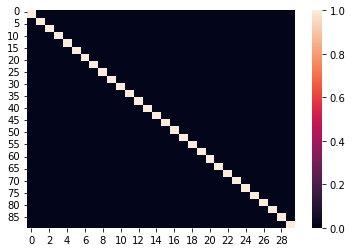

[49] loss: 0.098
tensor([[1.0000e+00, 1.3766e-25, 4.4430e-24,  ..., 3.9445e-24, 2.2932e-26,
         1.9993e-25],
        [1.0000e+00, 5.2856e-27, 2.4287e-26,  ..., 8.8982e-27, 7.5520e-31,
         8.1822e-29],
        [1.0000e+00, 3.4578e-28, 2.1815e-25,  ..., 3.5075e-25, 1.7079e-27,
         5.5654e-27],
        ...,
        [9.8381e-16, 4.9885e-24, 7.4575e-24,  ..., 2.7214e-21, 4.6021e-22,
         1.0000e+00],
        [8.0177e-17, 9.9182e-23, 1.5530e-21,  ..., 5.5662e-18, 3.1434e-24,
         1.0000e+00],
        [5.0390e-16, 4.3180e-24, 3.8401e-22,  ..., 1.8120e-21, 4.6154e-23,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)


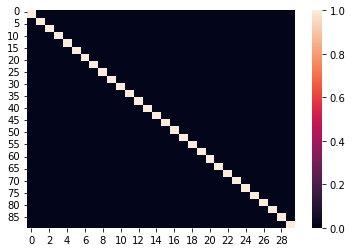

[50] loss: 0.098
Finished Training


In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
for epoch in range(10):  # loop over the dataset multiple times
    

    
    running_loss = 0.0
    # get the inputs
    inputs, labels = trainset_few_shot #data
    

    # zero the parameter gradients
    optimizer.zero_grad()
        
    outputs = m(inputs)
    print(outputs)
    sns.heatmap(outputs.detach())
    plt.show()
    #print(len(labels))
    #print(len(outputs))
    

        
    loss = criterion(outputs, labels)
    
    running_loss += loss.item()
    print('[%d] loss: %.3f' %
        (epoch + 1, running_loss / 25))
        
    loss.backward()
    optimizer.step()

    # print statistics
    
#     print('[%d] loss: %.3f' %
#         (epoch + 1, running_loss / 25))
        
    
    scheduler.step()

print('Finished Training')

In [9]:
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=6)

_class = [i for i in range(30)]
shot_number = 10

testset_few_shot = get_few_shot_learing_data(_class,shot_number,testloader)

Files already downloaded and verified


C:\PYTHON\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_14552\3293775616.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))
C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_14552\3293775616.py:26: UserWarning: To copy construct from a tensor, it is recommended

tensor([[1.0000e+00, 2.6732e-12, 8.3915e-11,  ..., 7.1246e-11, 1.9763e-12,
         1.9359e-12],
        [9.9996e-01, 1.5531e-09, 1.4222e-06,  ..., 5.0329e-09, 3.3530e-10,
         2.2154e-09],
        [1.0000e+00, 1.2474e-14, 1.8015e-12,  ..., 1.1360e-12, 1.0270e-12,
         6.7048e-11],
        ...,
        [7.5127e-01, 2.7396e-09, 2.9425e-07,  ..., 6.7728e-06, 9.5093e-08,
         6.4839e-02],
        [3.6458e-01, 1.1590e-08, 1.3049e-05,  ..., 1.9705e-04, 1.0227e-04,
         8.3755e-06],
        [3.5567e-01, 5.6870e-06, 9.1694e-06,  ..., 1.0838e-02, 1.6903e-08,
         1.5304e-04]], grad_fn=<SoftmaxBackward0>)


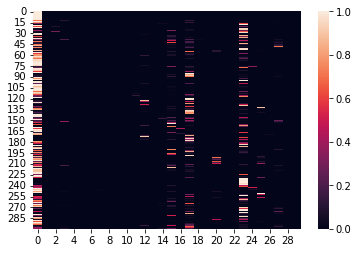

In [10]:
inputs, labels = testset_few_shot
outputs = m(inputs)
print(outputs)
sns.heatmap(outputs.detach())
plt.show()

In [11]:
y = torch.argmax(outputs, dim=1)

In [12]:
y

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 17,  0, 23,  0,
        23,  0,  0,  0,  0, 23, 17, 23,  0, 23,  0, 23,  0,  0,  0, 23,  0, 15,
        23,  0,  0, 15, 15,  0, 15, 23, 23,  0, 23,  0, 27,  0, 23, 23, 23, 23,
         0, 17,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 24, 23,  0,  0,  0,  0,  0, 15,  0, 17, 17, 17, 17, 17,
         0,  0,  0,  0,  0, 23,  0,  0,  0, 23,  0,  0,  0,  0, 23,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0, 15, 23, 23,  0, 23, 17, 17, 12,  0, 17,  0,
        23, 17, 12, 23, 15, 17, 25, 23,  0,  0, 17, 17, 17, 17, 17, 17,  0,  0,
         0,  0, 23, 17,  0,  0, 17,  3, 15,  0, 15, 17,  0, 23, 15, 27,  0,  0,
         0,  0,  0,  0,  0, 23,  0,  0,  0, 17, 12, 17, 23, 17, 23, 17, 17,  0,
         0, 17, 23, 23,  0,  0, 23,  0,  0,  0, 15,  0, 15, 17,  0, 17, 15,  0,
        17,  0,  0, 20,  0,  0,  0,  0,  0, 20,  0, 20, 17,  0,  0,  0,  0, 15,
         0,  0,  0,  0,  0,  0,  0,  0, 

In [13]:
sum(labels==y)

tensor(36)

In [14]:
y2=torch.randint(0,30,(300,))

In [15]:
sum(labels==y2)

tensor(9)

### PCAM

In [16]:
trainsetPCAM = torchvision.datasets.PCAM(root='./data',split = 'train',download=True, transform=transform)
trainloaderPCAM = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=False, num_workers=2)

_class = [0,1]

In [18]:
valsetPCAM = torchvision.datasets.PCAM(root='./data',split = 'val',download=True, transform=transform)
valloaderPCAM = torch.utils.data.DataLoader(valsetPCAM, batch_size=1,
                                          shuffle=False, num_workers=2)

_class = [0,1]

In [19]:
testsetPCAM = torchvision.datasets.PCAM(root='./data',split = 'test',download=True, transform=transform)
testloaderPCAM = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=2)

_class = [0,1]

In [20]:
def get_few_shot_learing_data_PCAM(_class,shot_number,trainloader):
    dataiter = trainloader
    _data = [ [] for i in range(len(_class))]
    _data_label = [ [] for i in range(len(_class))]

    for ind,data in enumerate(dataiter):
        image, label = dataiter[ind]
        print(label)
        if label in _class:
            if len(_data[label])!=shot_number:
                _data[label].append(image)
                _data_label[label].append(label)

        if sum([len(tab) for tab in _data]) ==   shot_number * len(_class):
             break
    print(_data_label)
    out_data= []
    out_label= [] 

    out_data_tensor = torch.Tensor(len(_class)*shot_number,3, 224, 224)
    out_label_tensor= torch.Tensor(len(_class)*shot_number)

    for i in range(len(_class)):
        for j in range(shot_number):
            out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))        
            out_label.append(torch.tensor([_data_label[i][j]]).clone().detach()) 
    print(out_data)
    print(out_label)
    torch.cat(out_data , out=out_data_tensor)    
    torch.cat(out_label , out=out_label_tensor)    
    out_data_tensor=out_data_tensor.squeeze()
    out_label_tensor = out_label_tensor.type(torch.long)
    trainset_few_shot = out_data_tensor.squeeze(),out_label_tensor.squeeze()
    return trainset_few_shot



In [21]:
_class = [0,1]
shot_number = 5

trainset_few_shot = get_few_shot_learing_data_PCAM(_class,shot_number,trainsetPCAM)

0
1
1
1
0
0
0
1
1
1
1
1
1
0
[[0, 0, 0, 0, 0], [1, 1, 1, 1, 1]]
[tensor([[[[ 1.7523,  1.7523,  1.7352,  ...,  1.3584,  1.1700,  1.1015],
          [ 1.7523,  1.7523,  1.7352,  ...,  1.2899,  1.1872,  1.1358],
          [ 1.7180,  1.7180,  1.7009,  ...,  1.1187,  1.2214,  1.2557],
          ...,
          [-0.6109, -0.5938, -0.5424,  ...,  1.2557,  1.3755,  1.4098],
          [-0.6452, -0.6281, -0.5253,  ...,  1.2728,  1.2557,  1.2385],
          [-0.6623, -0.6281, -0.5082,  ...,  1.2899,  1.2043,  1.1700]],

         [[ 1.6232,  1.6232,  1.6408,  ...,  0.9930,  0.8354,  0.7829],
          [ 1.6232,  1.6232,  1.6408,  ...,  0.9230,  0.8529,  0.8179],
          [ 1.6232,  1.6232,  1.6408,  ...,  0.7304,  0.8880,  0.9405],
          ...,
          [-1.1253, -1.1078, -1.0378,  ...,  0.2927,  0.4153,  0.4678],
          [-1.1429, -1.1078, -0.9853,  ...,  0.3452,  0.3102,  0.2927],
          [-1.1429, -1.1078, -0.9678,  ...,  0.3627,  0.2752,  0.2402]],

         [[ 2.1171,  2.1171,  2.1171, 

C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_14552\1753877152.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))


C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_14552\3293775616.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))
C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_14552\3293775616.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_label.append(torch.tensor(_data_label[i][j]).clone().detach())


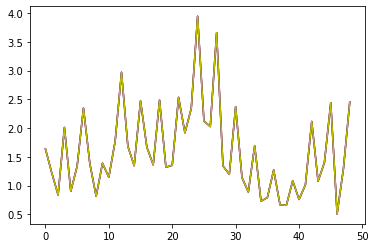

wybrane warstwy:  [24, 27, 12]


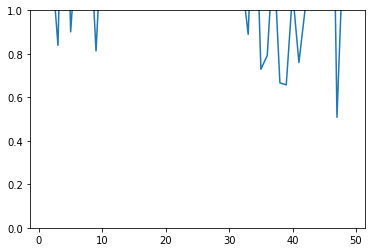

[12, 24, 27]
[[460, 459, 449, 409, 16, 99, 303, 183, 463, 51, 408, 74, 112, 461, 453, 103, 109, 29, 369, 203, 293, 306, 158, 53, 501, 244, 242, 96, 3, 168, 497, 219, 162, 93, 508, 261, 134, 364, 39, 90, 252, 423, 138, 433, 498, 360, 110, 213, 411, 368, 71, 23, 381, 476, 300, 455, 32, 307, 347, 237, 333, 469, 270, 68, 76, 256, 27, 118, 424, 11, 414, 280, 377, 220, 80, 406, 337, 330, 365, 46, 127, 89, 178, 442, 65, 427, 97, 496, 238, 37, 251, 344, 181, 150, 454, 503, 480, 169, 101, 315, 445, 223, 405, 336, 221, 174, 121, 248, 322, 217, 415, 386, 302, 478, 19, 95, 260, 124, 291, 2, 263, 435, 145, 294, 185, 137, 472, 370, 462, 52, 249, 87, 507, 142, 193, 155, 69, 77, 216, 271, 372, 492, 380, 49, 198, 304, 313, 234, 470, 214, 135, 323, 441, 264, 186, 47, 146, 179, 259, 72, 175, 353, 67, 227, 231, 98, 487, 296, 413, 348, 190, 421, 486, 276, 1, 204, 321, 272, 254, 341, 107, 444, 329, 479, 151, 63, 403, 177, 187, 473, 13, 373, 205, 404, 102, 56, 104, 136, 120, 229, 246, 148, 209, 55, 506, 201,

tensor([[0.4942, 0.5058],
        [0.4974, 0.5026],
        [0.4950, 0.5050],
        [0.4943, 0.5057],
        [0.4900, 0.5100],
        [0.4957, 0.5043],
        [0.4942, 0.5058],
        [0.4988, 0.5012],
        [0.4876, 0.5124],
        [0.4999, 0.5001],
        [0.5010, 0.4990],
        [0.4962, 0.5038],
        [0.4976, 0.5024],
        [0.4932, 0.5068],
        [0.4907, 0.5093],
        [0.4967, 0.5033],
        [0.4978, 0.5022],
        [0.4844, 0.5156],
        [0.4983, 0.5017],
        [0.4956, 0.5044],
        [0.4931, 0.5069],
        [0.4898, 0.5102],
        [0.4842, 0.5158],
        [0.5078, 0.4922],
        [0.4963, 0.5037],
        [0.4936, 0.5064],
        [0.5030, 0.4970],
        [0.4895, 0.5105],
        [0.4884, 0.5116],
        [0.5023, 0.4977],
        [0.4904, 0.5096],
        [0.4946, 0.5054],
        [0.4896, 0.5104],
        [0.5098, 0.4902],
        [0.4981, 0.5019],
        [0.4930, 0.5070],
        [0.4935, 0.5065],
        [0.4935, 0.5065],
        [0.5

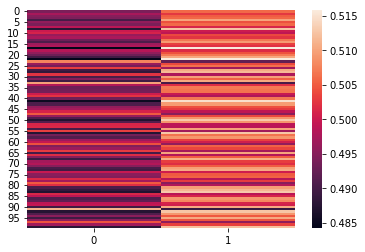

1 loss: 0.027734909057617187
tensor([[1.0000e+00, 3.2639e-22],
        [9.9936e-01, 6.3884e-04],
        [1.0000e+00, 2.8243e-25],
        [4.1527e-08, 1.0000e+00],
        [1.0000e+00, 9.3947e-12],
        [1.0000e+00, 2.7902e-11],
        [1.0000e+00, 1.9082e-15],
        [8.1995e-01, 1.8005e-01],
        [1.0000e+00, 1.3285e-24],
        [1.0000e+00, 8.5802e-09],
        [1.0000e+00, 4.8270e-09],
        [1.0000e+00, 6.5883e-11],
        [1.0000e+00, 4.1028e-10],
        [1.0000e+00, 1.4640e-29],
        [1.0000e+00, 1.5557e-15],
        [1.0000e+00, 6.9695e-13],
        [1.0000e+00, 1.4348e-09],
        [1.0000e+00, 2.7566e-16],
        [1.0000e+00, 1.3510e-24],
        [1.0000e+00, 1.2794e-14],
        [3.0159e-01, 6.9841e-01],
        [1.0000e+00, 1.2617e-06],
        [1.0000e+00, 1.4080e-09],
        [1.0000e+00, 1.3383e-26],
        [1.0000e+00, 7.0032e-31],
        [1.0000e+00, 3.9881e-34],
        [1.0000e+00, 5.0269e-10],
        [1.0000e+00, 5.6572e-15],
        [1.0000e+00

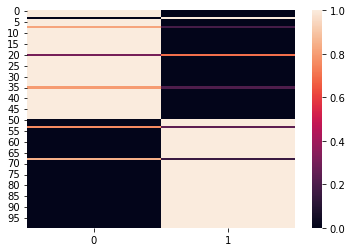

2 loss: 0.013845552206039429
tensor([[1.0000e+00, 5.8505e-40],
        [1.0000e+00, 2.6326e-11],
        [1.0000e+00, 2.8026e-45],
        [8.5370e-07, 1.0000e+00],
        [1.0000e+00, 2.4106e-24],
        [1.0000e+00, 2.0534e-22],
        [1.0000e+00, 2.5174e-29],
        [1.0000e+00, 1.0090e-10],
        [1.0000e+00, 1.0089e-43],
        [1.0000e+00, 1.5457e-19],
        [1.0000e+00, 8.0357e-20],
        [1.0000e+00, 1.8116e-22],
        [1.0000e+00, 3.0972e-22],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 4.8491e-29],
        [1.0000e+00, 2.5421e-25],
        [1.0000e+00, 8.1808e-20],
        [1.0000e+00, 1.5293e-30],
        [1.0000e+00, 1.9898e-43],
        [1.0000e+00, 5.5174e-28],
        [1.0000e+00, 4.7569e-16],
        [1.0000e+00, 9.6500e-15],
        [1.0000e+00, 5.5277e-20],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.5922e-20],
        [1.0000e+00, 9.3374e-30],
        [1.0000e+00

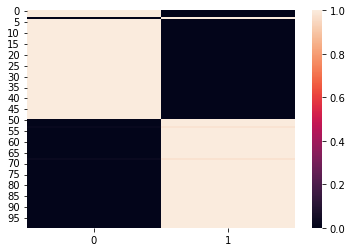

3 loss: 0.012941234111785889
tensor([[1.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0914e-15],
        [1.0000e+00, 0.0000e+00],
        [3.2607e-07, 1.0000e+00],
        [1.0000e+00, 1.1070e-32],
        [1.0000e+00, 9.2966e-30],
        [1.0000e+00, 1.1397e-38],
        [1.0000e+00, 1.5389e-16],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.8821e-26],
        [1.0000e+00, 8.8754e-27],
        [1.0000e+00, 4.0523e-30],
        [1.0000e+00, 3.7607e-30],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 4.4057e-38],
        [1.0000e+00, 1.2966e-33],
        [1.0000e+00, 2.1146e-26],
        [1.0000e+00, 3.8816e-40],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 5.4479e-37],
        [1.0000e+00, 7.6301e-27],
        [1.0000e+00, 1.1368e-19],
        [1.0000e+00, 1.2332e-26],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 6.5655e-27],
        [1.0000e+00, 7.7599e-40],
        [1.0000e+00

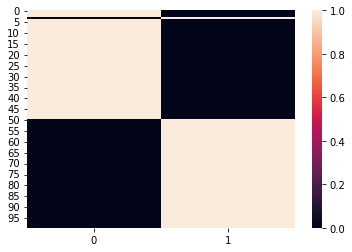

4 loss: 0.012930481433868409
tensor([[1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.8180e-19],
        [1.0000e+00, 0.0000e+00],
        [1.4762e-07, 1.0000e+00],
        [1.0000e+00, 1.6439e-39],
        [1.0000e+00, 8.9967e-36],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.6561e-21],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 4.0969e-32],
        [1.0000e+00, 1.7837e-32],
        [1.0000e+00, 2.2012e-36],
        [1.0000e+00, 1.2391e-36],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.4013e-45],
        [1.0000e+00, 2.0983e-40],
        [1.0000e+00, 8.5267e-32],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.2421e-44],
        [1.0000e+00, 1.1008e-35],
        [1.0000e+00, 1.0470e-23],
        [1.0000e+00, 4.4075e-32],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.6043e-32],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00

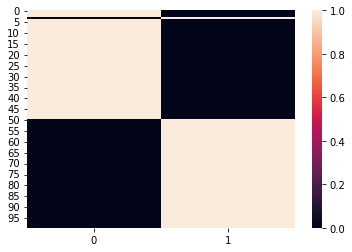

5 loss: 0.012930471897125245
tensor([[1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.6169e-22],
        [1.0000e+00, 0.0000e+00],
        [7.5445e-08, 1.0000e+00],
        [1.0000e+00, 2.8026e-45],
        [1.0000e+00, 7.4333e-41],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.5063e-25],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 6.7175e-37],
        [1.0000e+00, 2.7335e-37],
        [1.0000e+00, 1.1163e-41],
        [1.0000e+00, 4.1198e-42],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.3541e-36],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 3.7134e-43],
        [1.0000e+00, 4.0679e-27],
        [1.0000e+00, 1.0992e-36],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 7.0897e-37],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00

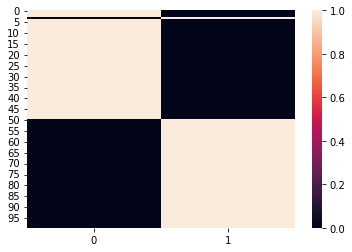

6 loss: 0.012930468320846558


KeyboardInterrupt: 

In [32]:
_class = [0,1]
shot_number = 50

#train
trainset_few_shot_pcamp = get_few_shot_learing_data(_class,shot_number,trainloaderPCAM)
m_pcam = ATL(trainset_few_shot_pcamp,3)


# trenowanie 
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(m.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(m_pcam.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

import seaborn as sns
from matplotlib import pyplot as plt
for epoch in range(50):  # loop over the dataset multiple times



    running_loss = 0.0
    # get the inputs
    inputs, labels = trainset_few_shot_pcamp #data


    # zero the parameter gradients
    optimizer.zero_grad()

    outputs = m_pcam(inputs)
    print(outputs)
    sns.heatmap(outputs.detach())
    plt.show()
    #print(len(labels))
    #print(len(outputs))



    loss = criterion(outputs, labels)

    running_loss += loss.item()
    print(f'{epoch + 1} loss: {running_loss / 25}')

    loss.backward()
    optimizer.step()

    # print statistics

#     print('[%d] loss: %.3f' %
#         (epoch + 1, running_loss / 25))

    
    scheduler.step()

print('Finished Training')


In [33]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])

In [40]:
#test
testset_few_shot_pcamp = get_few_shot_learing_data(_class,shot_number,testloaderPCAM)
inputs, labels = testset_few_shot_pcamp
outputs = m_pcam(inputs)
#print(outputs)
y = torch.argmax(outputs, dim=1)

print("accuracy_score")
accuracy_score(y,labels)

C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_14552\605319785.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))
C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_14552\605319785.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_label.append(torch.tensor(_data_label[i][j]).clone().detach())


accuracy_score


0.93